In [1]:
import dataloader
import sys
import time
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn import linear_model

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

%load_ext autoreload
%autoreload 2

path = "../032721Comparison/Data/SONY2021.csv"
date = datetime.datetime(2021,3,12)
count = 1200
# We will use the previous 60 days as features
history_size = 60

In [2]:
# Compute MAE
def mae(y_hat, y):
    # mean absolute error
    return np.abs(y_hat - y).mean()

def rmse(y_hat, y):
    # root mean squared error
    return np.sqrt(np.mean(np.power((y-y_hat),2)))

In [3]:
df = dataloader.load_data_up_to_date(path, date, count)

(1258, 7)
(1257, 7)
(1257, 7)
(1200, 7)


In [4]:
sony_closing_all = df['Close'].to_numpy()
# reshape to 1200 x 1 matrix
sony_closing_all = np.reshape(sony_closing_all, (sony_closing_all.shape[0], -1))
sony_closing_all.shape

(1200, 1)

In [5]:
#converting prices to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sony_closing_all)
train = scaled_data[:1000,:]
test = scaled_data[1000:, :]

In [6]:
train_x, train_y = [], []
test_x, test_y = [], []
for i in range(history_size,len(train)):
    train_x.append(scaled_data[i-history_size:i,0])
    train_y.append(scaled_data[i,0])
train_x, train_y = np.array(train_x), np.array(train_y)

train_x = np.reshape(train_x, (train_x.shape[0],train_x.shape[1]))
print(train_x.shape)

for i in range(len(train),len(scaled_data)):
    test_x.append(scaled_data[i-history_size:i,0])
    test_y.append(scaled_data[i,0])
test_x, test_y = np.array(test_x), np.array(test_y)

test_x = np.reshape(test_x, (test_x.shape[0],test_x.shape[1]))
print(test_x.shape)

(940, 60)
(200, 60)


In [7]:
KS = [5]  # Possible Splits for Cross Validation
ALPHAS = [10**-6, 10**-4, 10**-2, 1, 10]  # Model Smooth Constant

In [8]:
# Vars to store results
cval_errs = {} # Mean validation errors
train_time = {} # Training time
# Best Model
best_l_regressor = None
# Best Validation Error
best_err = sys.maxsize


for K in KS:
    for a in ALPHAS:
        for regor in [linear_model.Ridge, linear_model.Lasso]:
            kf = KFold(n_splits=K, random_state=None, shuffle=False)
            y_err = []

            start = time.time()

            # Cross Validaiton
            for train_index, val_index in kf.split(train_x):
            #     print("TRAIN:", train_index, "VAL:", val_index)
                X_train, X_val = train_x[train_index], train_x[val_index]
                y_train, y_val = train_y[train_index], train_y[val_index]

                LRegressor = regor(alpha=a)
                y_hat = LRegressor.fit(X_train, y_train).predict(X_val)
            #     print(y_hat)
                y_err.append(rmse(y_hat, y_val))

            end = time.time()

            print(str(regor.__name__), str(a), "mean val RMSE:", np.mean(y_err))
#             print("Time lapsed", str((end - start)*1000))

            # add to dict
            cval_errs[regor.__name__+str(a)] = np.mean(y_err)
            train_time[regor.__name__+str(a)] = (end - start)*1000
            if np.mean(y_err) < best_err:
                best_af_l_regressor = regor(alpha=a)
                best_k = K
                best_err = np.mean(y_err)
                best_errs = y_err
                
print(best_af_l_regressor, best_err)

Ridge 1e-06 mean val RMSE: 0.010251109751758223
Lasso 1e-06 mean val RMSE: 0.010056907792517528
Ridge 0.0001 mean val RMSE: 0.010246171035393842


/home/will/anaconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008083856840030712, tolerance: 0.0006841520144179401
  model = cd_fast.enet_coordinate_descent(
/home/will/anaconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022229977762185736, tolerance: 0.0013080655988425539
  model = cd_fast.enet_coordinate_descent(
/home/will/anaconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022907754814890074, tolerance: 0.001360975120237256
  model = cd_fast.enet_coordinate_descent(
/home/will/anaconda3/envs/tf_gpu/l

Lasso 0.0001 mean val RMSE: 0.01000586435916382
Ridge 0.01 mean val RMSE: 0.010065901024025783
Lasso 0.01 mean val RMSE: 0.11327975983856434
Ridge 1 mean val RMSE: 0.01545640185462519
Lasso 1 mean val RMSE: 0.13185749867607957
Ridge 10 mean val RMSE: 0.025542801804929727
Lasso 10 mean val RMSE: 0.13185749867607957
Lasso(alpha=0.0001) 0.01000586435916382


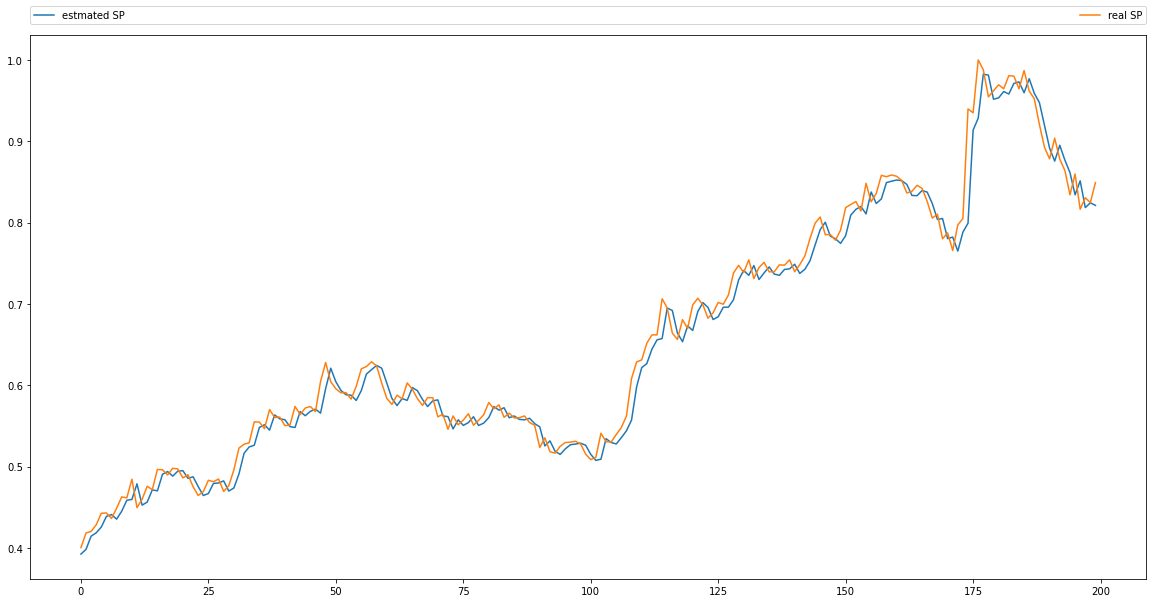

In [9]:
best_af_l_regressor = best_af_l_regressor.fit(train_x, train_y)
y_hat = best_af_l_regressor.predict(test_x)
plt.plot(y_hat[:], label="estmated SP")
plt.plot(test_y[:], label="real SP")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

In [10]:
print("MAE:  ", mae(y_hat, test_y))
print("RMSE: ", rmse(y_hat, test_y))

MAE:   0.013879187194078452
RMSE:  0.019718227912093492


Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

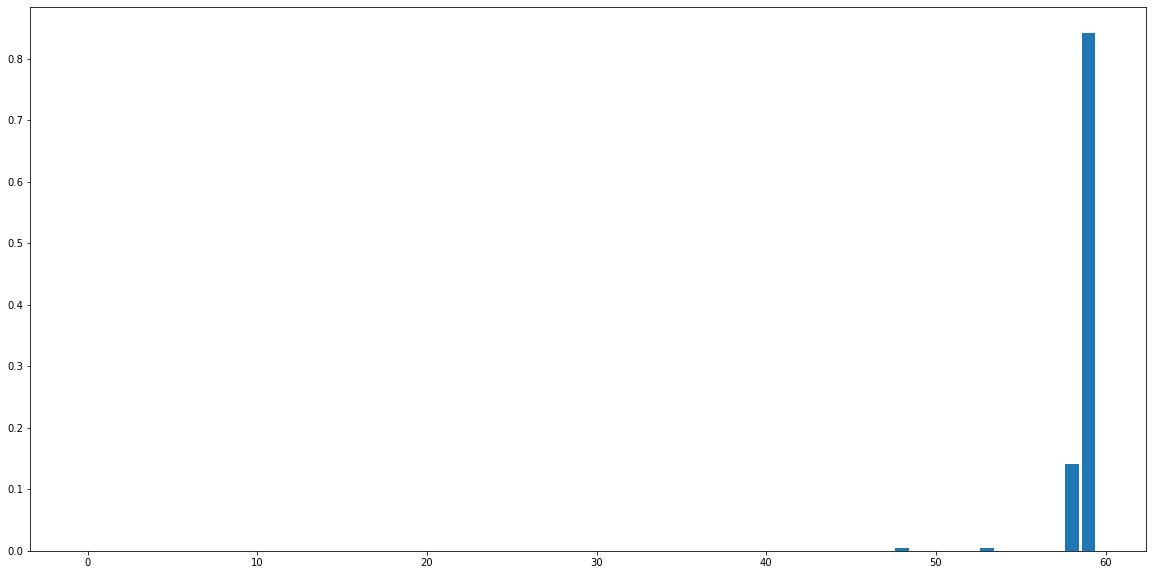

In [11]:
importance = best_af_l_regressor.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()